In [1]:
uncleaned_filepath = '/content/crop_part1.tar.gz'
cleaned_filepath = '/content/crop_part1_clean.tar.gz'

In [2]:
import os
import tarfile

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

def removefile(filename):
  prefix, ext = os.path.splitext(filename)
  newFilename = 'crop_part1_clean.tar.gz'
  orig = tarfile.open(filename)
  mod = tarfile.open(newFilename, 'w')

  for info in orig.getmembers():
    age_str = info.name.replace('crop_part1/', '').split('_')[0]
    try:
      age = int(age_str)
      extracted = orig.extractfile(info)
      mod.addfile(info, extracted)
    except Exception:
      print(info.name)
      continue
    
  orig.close()
  mod.close()

if not os.path.exists(cleaned_filepath):
  removefile(uncleaned_filepath)

crop_part1


In [17]:
import torch
import torchvision
import torch.utils.tensorboard as tb
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import math
from skimage import io, transform
import torch.nn as nn
from os import path
import torchtext
import torchvision.models as models
import torch.optim as optim
import cv2
import torch.nn.functional as F

In [5]:
class FaceDataset(Dataset):

  def __init__(self, root_dir, transform=None):
    self.info = torchtext.utils.extract_archive(root_dir)
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.info)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    file = self.info[idx]
    image = io.imread(file)
    image = cv2.resize(image, (64, 64))
    image = transforms.ToTensor()(image)

    age = int(file.replace('/content/crop_part1/', '').split('_')[0])
    
    if self.transform:
      image = self.transform(image)
    
    return (image, torch.tensor(age))

In [78]:
data = FaceDataset(cleaned_filepath)

## Data Visualization and Utility Functions

9 torch.Size([3, 64, 64])


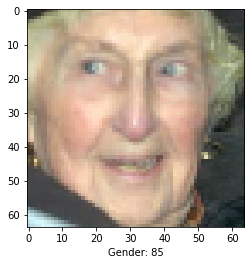

10 torch.Size([3, 64, 64])


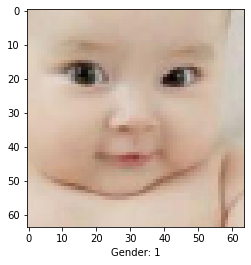

11 torch.Size([3, 64, 64])


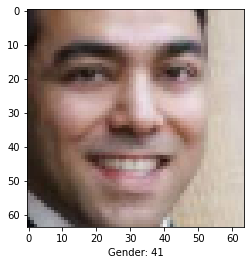

In [8]:
for i in range(9,12):
    sample = data[i]

    print(i, sample[0].shape)
    plt.xlabel("Gender: {}".format(sample[1]))
    plt.imshow(sample[0].permute(1, 2, 0).numpy())
    plt.show()

In [47]:
combined_data_len = len(data)
# first split train/test with 80/20 split
train, test = torch.utils.data.random_split(data, [int(combined_data_len * .80), int(combined_data_len * .20)])

train1_len = len(train)
# then split train into train/valid with a 75/25 split
train, valid = torch.utils.data.random_split(train, [int(train1_len * .75), int(train1_len * .25)])

In [8]:
batch_size = 64
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)

In [81]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import time

def final_score(model, device, test_loader, classes=117):
  model = model.to(device)
  model.eval()
  preds = []
  true = []
  start =  time.time()

  for i, data in enumerate(test_loader):
    inputs, labels = data 
    inputs = inputs.to(device)
    size = inputs.size(0)
    pred = torch.argmax(model(inputs), dim = 1).tolist()
    pred = map(int, pred)
    preds.extend(list(pred))
    true.extend(labels.tolist())

  precision = precision_score(true, preds, average='weighted')
  recall = recall_score(true, preds, average='weighted')
  f1 = f1_score(true, preds, average='weighted')

  cm = confusion_matrix(true, preds)
  df_cm = pd.DataFrame(cm, range(classes), range(classes))

  fig, ax = plt.subplots(figsize=(10,10))
  sns.heatmap(df_cm, annot=True, annot_kws={"size": classes}, ax=ax) # font size
  plt.show()

  end = time.time()

  return precision, recall, f1, (end-start)

In [13]:
def graph_train_valid(train_data, valid_data, title, num):
  epochs = len(train_data)
  plt.plot(range(epochs), train_data, label="training {}".format(title))
  plt.plot(range(epochs), valid_data, label = 'validation {}'.format(title))
  plt.title('Age Model {} {}'.format(num, title))
  plt.xlabel("epochs")
  plt.ylabel(title)
  plt.legend()
  plt.show()

In [14]:
def init_weights(net):
    """
    Usage: net = Model()
           net.apply(init_weights)
    """
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.ones_(m.weight)
            nn.init.zeros_(m.bias)
        elif isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)

In [50]:
def train(args, save=False):
    device = torch.device("cuda")
    model = args.model.to(device)
    optimizer = optim.Adam(params=model.parameters(), lr=args.learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, args.step, gamma=0.1, last_epoch=-1, verbose=True)
    criterion = torch.nn.CrossEntropyLoss()
    train_loader, valid_loader = args.train, args.valid 

    train_loss_history, valid_loss_history, train_acc_history, valid_acc_history = [], [], [], []
    if args.init_weight:
      model.apply(init_weights)
      

    for epoch in range(args.epochs):
      model.train()
      train_loss = 0.0
      valid_loss = 0.0
      train_accuracy = 0.0
      valid_accuracy = 0.0
      total_train = 0
      total_val = 0

      for i, data in enumerate(train_loader, 1):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_accuracy += (predicted == labels).float().sum() 
        total_train += inputs.size(0)

      for j, data in enumerate(valid_loader, 1):
        model.eval()
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        valid_loss += (loss.item() * inputs.size(0))
        _, predicted = torch.max(outputs.data, 1)
        valid_accuracy += (predicted == labels).float().sum() 
        total_val += inputs.size(0)
      
      scheduler.step()
      train_loss = train_loss/total_train
      valid_loss = valid_loss/total_val
      train_accuracy = train_accuracy/total_train
      valid_accuracy = valid_accuracy/total_val
      
      train_loss_history.append(train_loss)
      valid_loss_history.append(valid_loss)
      train_acc_history.append(train_accuracy)
      valid_acc_history.append(valid_accuracy)
      print("Training Loss: {} Valid Loss: {} Training Accuracy: {} Valid Accuracy: {}"
      .format(train_loss, valid_loss, train_accuracy, valid_accuracy))
    
    if save:
      torch.save(model, 'model')

    return (train_loss_history, valid_loss_history, train_acc_history, valid_acc_history)

# Testing prediction with no classes

In [16]:
from torchsummary import summary

class BaselineClassifier(nn.Module):
    def __init__(self):
        super(BaselineClassifier, self).__init__() 
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=4, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=4, stride=2, padding=0)
        self.fc1 = nn.Linear(3136, 128) 
        self.out = nn.Linear(128, 117) 

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.out(x)
        
        return x

device = torch.device("cuda")
model = BaselineClassifier()
summary(model.to(device), (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 31, 31]             392
            Conv2d-2           [-1, 16, 14, 14]           2,064
            Linear-3                  [-1, 128]         401,536
            Linear-4                  [-1, 117]          15,093
Total params: 419,085
Trainable params: 419,085
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 0.08
Params size (MB): 1.60
Estimated Total Size (MB): 1.73
----------------------------------------------------------------


In [ ]:
import torch.optim as optim
class Args(object):
    pass

args1 = Args();
args1.learning_rate = .005
args1.regularization = 5e-4

args1.model = BaselineClassifier()
args1.train = train_loader
args1.valid = valid_loader 
args1.epochs = 10
args1.step = 5
args1.init_weight = True

train_loss, valid_loss, train_accuracy, valid_accuracy = train(args1)

Training Loss: 4.248792505621829 Valid Loss: 4.024916406545659 Training Accuracy: 0.09662576764822006 Valid Accuracy: 0.10812883079051971
Training Loss: 3.9742720931585582 Valid Loss: 3.952417190333329 Training Accuracy: 0.12125085294246674 Valid Accuracy: 0.10838445276021957
Training Loss: 3.8901562297433596 Valid Loss: 3.901379722271473 Training Accuracy: 0.12474437803030014 Valid Accuracy: 0.11886502802371979
Training Loss: 3.840340668275881 Valid Loss: 3.8756723399055026 Training Accuracy: 0.13011248409748077 Valid Accuracy: 0.11860940605401993
Training Loss: 3.7788679453492895 Valid Loss: 3.855133940105789 Training Accuracy: 0.13224267959594727 Valid Accuracy: 0.12372187525033951
Training Loss: 3.7342480945197107 Valid Loss: 3.792517370485333 Training Accuracy: 0.13914451003074646 Valid Accuracy: 0.12678936123847961
Training Loss: 3.6837824645624244 Valid Loss: 3.7608904399754812 Training Accuracy: 0.14221200346946716 Valid Accuracy: 0.12960122525691986
Training Loss: 3.6415073535

In [ ]:
print(train_accuracy[-1].item(), valid_accuracy[-1].item())

0.15337423980236053 0.13087934255599976


# Adjusting For Classes

Using 6 different cutoffs (0-5, 6-12, 13-30, 31-45, 46-60, 61+)

In [28]:
def get_age_class(age):
  if age <= 5:
    return 0
  
  if age <= 12:
    return 1
  
  if age <= 30:
    return 2

  if age <= 45:
    return 3

  if age <= 60:
    return 4
  
  return 5

class FaceDataset2(Dataset):

  def __init__(self, root_dir, transform=None):
    self.info = torchtext.utils.extract_archive(root_dir)
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.info)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    file = self.info[idx]
    image = io.imread(file)
    image = cv2.resize(image, (64, 64))
    image = transforms.ToTensor()(image)

    age = int(file.replace('/content/crop_part1/', '').split('_')[0])

    age_class = get_age_class(age)
    if self.transform:
      image = self.transform(image)
    
    return (image, torch.tensor(age_class))

In [48]:
data2 = FaceDataset2(cleaned_filepath)
augmented_data2 = FaceDataset2(cleaned_filepath, data_transforms)
combined_data2 = torch.utils.data.ConcatDataset([data2, augmented_data2])


combined_data_len2 = len(data2)
# first split train/test with 80/20 split
train2a, test2 = torch.utils.data.random_split(data2, [int(combined_data_len2 * .80), int(combined_data_len2 * .20)])

train2a_len = len(train2a)
# then split train into train/valid with a 75/25 split
train2, valid2 = torch.utils.data.random_split(train2a, [int(train2a_len * .75), int(train2a_len * .25)])

train_loader2 = DataLoader(train2, batch_size=batch_size, shuffle=True)
valid_loader2 = DataLoader(valid2, batch_size=batch_size, shuffle=True)
test_loader2 = DataLoader(test2, batch_size=batch_size, shuffle=True)

Using googlenet as baseline

In [88]:
model = torch.hub.load('pytorch/vision:v0.9.0', 'googlenet', pretrained=True)
for param in model.parameters():
    param.requires_grad = False

# add dropout to prevent overfitting 
model.fc = nn.Sequential(
     nn.Dropout(.25),
     nn.Linear(model.fc.in_features, 6)
)

# only fine tune last layer
i = 0 
for param in model.parameters():
  if i == 172:
    param.requires_grad = True
  else:
    param.requires_grad = False
  i += 1


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


In [89]:
class Args(object):
    pass

args_tl = Args();
args_tl.learning_rate = 0.005
args_tl.regularization = 5e-4

args_tl.train = train_loader2
args_tl.valid = valid_loader2
args_tl.epochs = 25
args_tl.init_weight = False
args_tl.step = 10

args_tl.model = model

train_loss_tl, valid_loss_tl, train_accuracy_tl, valid_accuracy_tl = train(args_tl)

Adjusting learning rate of group 0 to 5.0000e-03.
Adjusting learning rate of group 0 to 5.0000e-03.
Training Loss: 1.8357015803466463 Valid Loss: 1.7833509771858012 Training Accuracy: 0.19325153529644012 Valid Accuracy: 0.22188138961791992
Adjusting learning rate of group 0 to 5.0000e-03.
Training Loss: 1.8156013244175147 Valid Loss: 1.7761845079180165 Training Accuracy: 0.2174505889415741 Valid Accuracy: 0.22903884947299957
Adjusting learning rate of group 0 to 5.0000e-03.
Training Loss: 1.8103780711517905 Valid Loss: 1.7789459981801319 Training Accuracy: 0.22937969863414764 Valid Accuracy: 0.23159508407115936
Adjusting learning rate of group 0 to 5.0000e-03.
Training Loss: 1.8157679278913939 Valid Loss: 1.7797516372306215 Training Accuracy: 0.23040218651294708 Valid Accuracy: 0.2295500934123993
Adjusting learning rate of group 0 to 5.0000e-03.
Training Loss: 1.8084239072351125 Valid Loss: 1.7791959810354472 Training Accuracy: 0.22597137093544006 Valid Accuracy: 0.22597137093544006
Ad

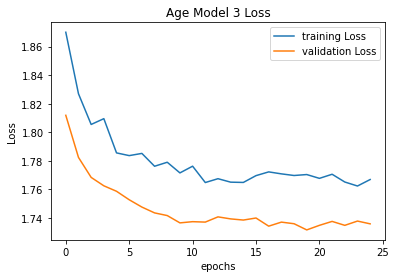

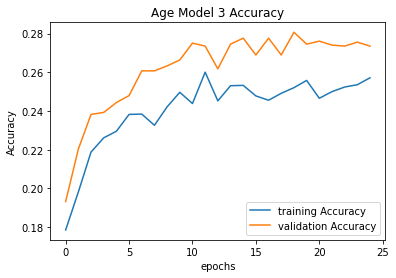

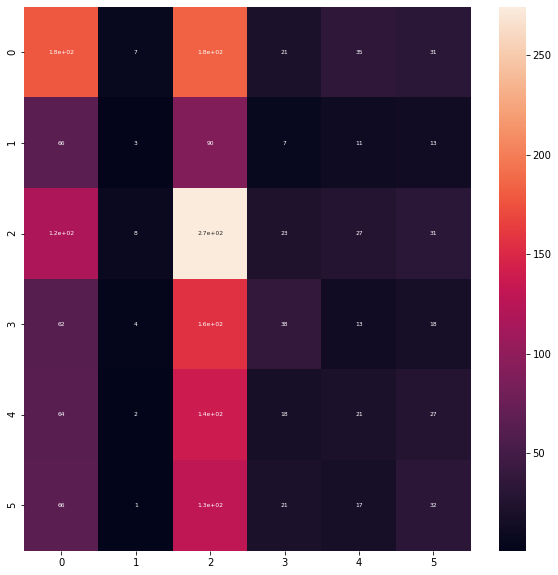

Test Precision: 0.25261262041902816 Test Recall: 0.2796523517382413 Test F1: 0.2406570498079157 Total Time: 2.927609443664551 seconds


In [76]:
graph_train_valid(train_loss_tl, valid_loss_tl, 'Loss', 3)

graph_train_valid(train_accuracy_tl, valid_accuracy_tl, 'Accuracy', 3)

precision_tl, recall_tl, f1_tl, time_tl = final_score(args_tl.model, device, test_loader2, 6)

print("Test Precision: {} Test Recall: {} Test F1: {} Total Time: {} seconds".format(precision_tl, recall_tl, f1_tl, time_tl))

In [92]:
class AgeClassifier2(nn.Module):
    def __init__(self):
        super(AgeClassifier2, self).__init__() 
        self.dropout1 = nn.Dropout(.25)
        self.dropout2 = nn.Dropout(.5)
        self.pool1 = nn.MaxPool2d((2, 2), (2, 2))
        self.pool2 = nn.MaxPool2d((2, 2))

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, bias=True)
        self.batch1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, bias=False)
        self.batch2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, bias=False)
        self.batch3 = nn.BatchNorm2d(256)

        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, bias=False)
        self.batch4 = nn.BatchNorm2d(512)

        self.fc1 = nn.Linear(in_features=2048, out_features=512, bias=False)
        self.fc2 = nn.Linear(in_features=512, out_features=6, bias=False)
        # self.fc3 = nn.Linear(in_features=256, out_features=6, bias=False)

    def forward(self, x):
        x = self.pool1(self.batch1(F.relu(self.conv1(x))))
        x = self.dropout1(self.pool2(self.batch2(F.relu(self.conv2(x)))))
        x = self.pool2(self.batch3(F.relu(self.conv3(x))))
        x = self.dropout1(self.pool2(self.batch4(F.relu(self.conv4(x)))))

        x = torch.flatten(x, 1)
        x = self.dropout2(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

device = torch.device("cuda")
model = AgeClassifier2()
summary(model.to(device), (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 62, 62]           1,792
       BatchNorm2d-2           [-1, 64, 62, 62]             128
         MaxPool2d-3           [-1, 64, 31, 31]               0
            Conv2d-4          [-1, 128, 29, 29]          73,728
       BatchNorm2d-5          [-1, 128, 29, 29]             256
         MaxPool2d-6          [-1, 128, 14, 14]               0
           Dropout-7          [-1, 128, 14, 14]               0
            Conv2d-8          [-1, 256, 12, 12]         294,912
       BatchNorm2d-9          [-1, 256, 12, 12]             512
        MaxPool2d-10            [-1, 256, 6, 6]               0
           Conv2d-11            [-1, 512, 4, 4]       1,179,648
      BatchNorm2d-12            [-1, 512, 4, 4]           1,024
        MaxPool2d-13            [-1, 512, 2, 2]               0
          Dropout-14            [-1, 51

In [93]:
args2 = Args()
args2.learning_rate = .0015
args2.regularization = 6e-4
args2.log_dir = 'logdir' 

args2.model = AgeClassifier2()
args2.train = train_loader2
args2.valid = valid_loader2
args2.epochs = 35 
args2.init_weight = True
args2.step = 10
train_loss2, valid_loss2, train_accuracy2, valid_accuracy2 = train(args2)

Adjusting learning rate of group 0 to 1.5000e-03.
Adjusting learning rate of group 0 to 1.5000e-03.
Training Loss: 1.9737514324064716 Valid Loss: 2.0731653328565978 Training Accuracy: 0.4233129024505615 Valid Accuracy: 0.39775049686431885
Adjusting learning rate of group 0 to 1.5000e-03.
Training Loss: 1.1108260998209074 Valid Loss: 1.2309685572524744 Training Accuracy: 0.5586230754852295 Valid Accuracy: 0.5833333134651184
Adjusting learning rate of group 0 to 1.5000e-03.
Training Loss: 0.9740588480140696 Valid Loss: 1.3163179295682224 Training Accuracy: 0.6013974547386169 Valid Accuracy: 0.5209611058235168
Adjusting learning rate of group 0 to 1.5000e-03.
Training Loss: 0.8945376859202057 Valid Loss: 0.8900311867152255 Training Accuracy: 0.6230402588844299 Valid Accuracy: 0.6324130892753601
Adjusting learning rate of group 0 to 1.5000e-03.
Training Loss: 0.8164698475871512 Valid Loss: 0.8622672655343522 Training Accuracy: 0.6589979529380798 Valid Accuracy: 0.6671779155731201
Adjusting

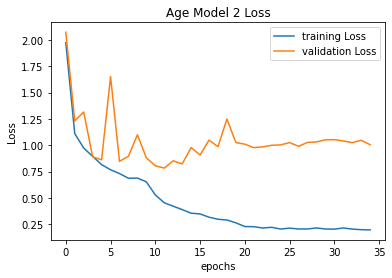

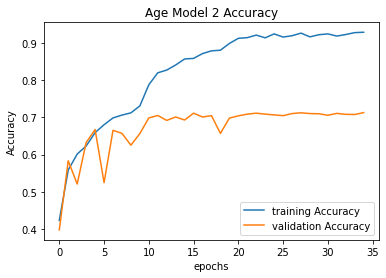

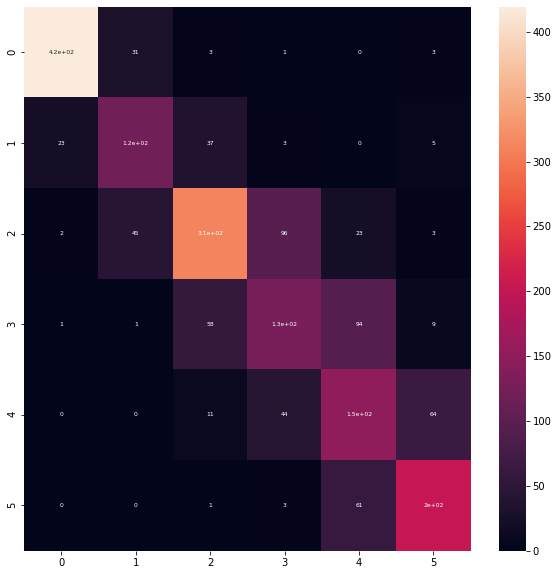

Test Precision: 0.6903633980048229 Test Recall: 0.6820040899795501 Test F1: 0.6845306577311975 Total Time: 2.5576891899108887 seconds


In [94]:
graph_train_valid(train_loss2, valid_loss2, 'Loss', 2)

graph_train_valid(train_accuracy2, valid_accuracy2, 'Accuracy', 2)

precision2, recall2, f1_2, time2 = final_score(args2.model, device, test_loader2, 6)

print("Test Precision: {} Test Recall: {} Test F1: {} Total Time: {} seconds".format(precision2, recall2, f1_2, time2))